In [2]:
!git clone https://github.com/Rafael1s/Deep-Reinforcement-Learning-Algorithms.git

Cloning into 'Deep-Reinforcement-Learning-Algorithms'...
remote: Enumerating objects: 4050, done.
remote: Counting objects: 100% (424/424), done.
remote: Compressing objects: 100% (221/221), done.
remote: Total 4050 (delta 227), reused 396 (delta 203), pack-reused 3626 (from 1)
Receiving objects: 100% (4050/4050), 110.01 MiB | 25.91 MiB/s, done.
Resolving deltas: 100% (2423/2423), done.


In [3]:
cd /content/Deep-Reinforcement-Learning-Algorithms/Minitaur-Soft-Actor-Critic

/content/Deep-Reinforcement-Learning-Algorithms/Minitaur-Soft-Actor-Critic


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
!pip install pybullet

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 MB 7.8 MB/s eta 0:00:00


In [6]:
import gym

import pybullet_envs
import pybullet_envs.bullet as bul
import numpy as np
import torch
from sac_agent import soft_actor_critic_agent, device
from replay_memory import ReplayMemory

seed=0
env = gym.make('MinitaurBulletEnv-v0')
torch.manual_seed(seed)
np.random.seed(seed)
env.seed(seed)
max_steps = env._max_episode_steps
print('max_steps: ', max_steps)

batch_size=128 ##  512
LEARNING_RATE=0.0001
start_steps=10000 ## Steps sampling random actions
replay_size=1000000 ## size of replay buffer

agent = soft_actor_critic_agent(env.observation_space.shape[0], env.action_space, \
        hidden_size=256, seed=seed, lr=LEARNING_RATE, gamma=0.99, tau=0.005, alpha=0.2)

memory = ReplayMemory(replay_size)

print('device: ', device)
print('leraning rate: ', LEARNING_RATE)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

print('state_dim: ',state_dim, ', action_dim: ', action_dim)

threshold = env.spec.reward_threshold
print('threshold: ', threshold)


/usr/local/lib/python3.11/dist-packages/gym/envs/registration.py:440: UserWarning: WARN: The `registry.env_specs` property along with `EnvSpecTree` is deprecated. Please use `registry` directly as a dictionary instead.
  logger.warn(
/usr/local/lib/python3.11/dist-packages/pybullet_envs/bullet/cartpole_bullet.py:21: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import parse_version
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.dec

current_dir=/usr/local/lib/python3.11/dist-packages/pybullet_envs/bullet
device:  cpu
urdf_root=/usr/local/lib/python3.11/dist-packages/pybullet_data


/usr/local/lib/python3.11/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


max_steps:  1000
device:  cpu
leraning rate:  0.0001
state_dim:  28 , action_dim:  8
threshold:  15.0


In [7]:
def save(agent, directory, filename, episode, reward):
    torch.save(agent.policy.state_dict(), '%s/%s_actor_%s_%s.pth' % (directory, filename, episode, reward))
    torch.save(agent.critic.state_dict(), '%s/%s_critic_%s_%s.pth' % (directory, filename, episode, reward))

In [17]:
import time
import numpy as np
from collections import deque

def sac_train(max_steps, start_steps, threshold, env, agent, memory, batch_size):

    total_numsteps = 0
    updates = 0
    num_episodes = 40000

    time_start = time.time()
    scores_deque = deque(maxlen=100)
    scores_array = []
    avg_scores_array = []
    num_steps_deque = deque(maxlen=100)
    avg_numm_steps_array = []

    for i_episode in range(num_episodes):
        episode_reward = 0
        episode_steps = 0
        done = False
        state = env.reset()

        for step in range(max_steps):
            if start_steps > total_numsteps:
                action = env.action_space.sample()  # Sample random action
            else:
                action = agent.select_action(state)  # Sample action from policy

            if len(memory) > batch_size:
                # Update parameters of all the networks
                agent.update_parameters(memory, batch_size, updates)
                updates = updates + 1

            next_state, reward, done, _ = env.step(action)  # Step
            episode_steps = episode_steps + 1
            total_numsteps = total_numsteps + 1
            episode_reward = episode_reward + reward

            mask = 1 if episode_steps == env._max_episode_steps else float(not done)

            memory.push(state, action, reward, next_state, mask)  # Append transition to memory

            state = next_state

            if done:
                break

        scores_deque.append(episode_reward)
        scores_array.append(episode_reward)
        avg_score = np.mean(scores_deque)
        avg_scores_array.append(avg_score)
        min_score = np.min(scores_deque)
        max_score = np.max(scores_deque)
        num_steps_deque.append(episode_steps)
        avg_num_steps = np.mean(num_steps_deque)
        avg_numm_steps_array.append(avg_num_steps)

        # Saving the model every 500 episodes
        if i_episode % 500 == 0 and i_episode > 0:
            reward_round = round(episode_reward, 2)
            save(agent, 'dir_lr0.0001', 'weights', str(i_episode), str(reward_round))

        s = int(time.time() - time_start)

        # Displaying the progress every 10 episodes
        if i_episode % 10 == 0 and i_episode > 0:
            print("Ep.: {}, Tot.St.: {}, Avg.Num.St.: {:.1f}, Min-Max.Sc.: ({:.2f}, {:.2f}), Avg.Score: {:.3f}, Time: {:02}:{:02}:{:02}".\
                format(i_episode, total_numsteps, avg_num_steps, min_score, max_score, avg_score, \
                  s//3600, s%3600//60, s%60))

        # Checking if the environment is solved
        if avg_score >= threshold:
            print('Solved environment with Avg Score:  ', avg_score)
            break

    return scores_array, avg_scores_array, avg_numm_steps_array

# Example call to `sac_train` function
# Ensure you have the following variables initialized
# start_steps = 1000  # e.g., number of random actions before starting training
# max_steps = 1000    # e.g., maximum steps per episode
# threshold = 300     # e.g., score threshold to consider environment solved
# env = ...           # Your environment (e.g., OpenAI Gym environment)
# agent = ...         # Your agent (e.g., SAC agent)
# memory = ...        # Your replay buffer
# batch_size = 64     # Your batch size for training

scores, avg_scores, avg_numm_steps = sac_train(max_steps=max_steps,
                                                start_steps=start_steps,
                                                threshold=threshold,
                                                env=env,
                                                agent=agent,
                                                memory=memory,
                                                batch_size=batch_size)


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: Error detected in AddmmBackward0. Traceback of forward call that caused the error:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 619, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever
    self._run_once()
  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once
    handle._run()
  File "/usr/lib/python3.1

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [256, 1]], which is output 0 of AsStridedBackward0, is at version 12; expected version 11 instead. Hint: the backtrace further above shows the operation that failed to compute its gradient. The variable in question was changed in there or anywhere later. Good luck!

In [ ]:
reward_round = round(np.max(scores), 2)
save(agent, 'dir_lr0.0001', 'weights', 'final', str(reward_round))

length of scores:  1745 , len of avg_scores:  1745


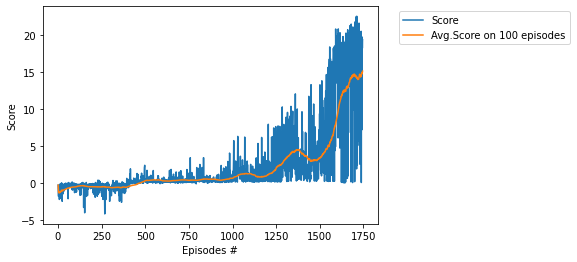

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

print('length of scores: ', len(scores), ', len of avg_scores: ', len(avg_scores))

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores, label="Score")
plt.plot(np.arange(1, len(avg_scores)+1), avg_scores, label="Avg.Score on 100 episodes")
## plt.plot(np.arange(1, len(avg_numm_steps)+1), avg_numm_steps, label="Avg.Num.Steps on 100 episodes")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.ylabel('Score')
plt.xlabel('Episodes #')
plt.show()

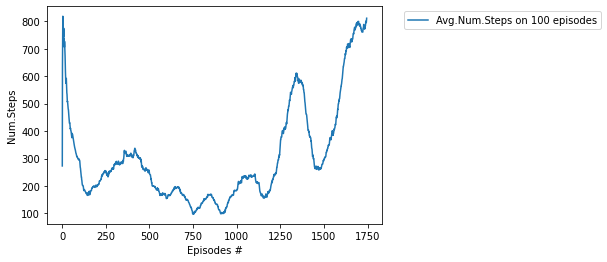

In [ ]:
fig2 = plt.figure()
ax = fig2.add_subplot(111)
# plt.plot(np.arange(1, len(scores)+1), scores, label="Score")
# plt.plot(np.arange(1, len(avg_scores)+1), avg_scores, label="Avg.Score on 100 episodes")
plt.plot(np.arange(1, len(avg_numm_steps)+1), avg_numm_steps, label="Avg.Num.Steps on 100 episodes")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.ylabel('Num.Steps')
plt.xlabel('Episodes #')
plt.show()

In [ ]:
def play(env, agent, num_episodes):

    state = env.reset()
    scores_deque = deque(maxlen=100)
    scores = []

    for i_episode in range(num_episodes + 1):

        state = env.reset()
        score = 0
        time_start = time.time()

        while True:

            action = agent.select_action(state, eval=False)
            env.render()
            next_state, reward, done, _ = env.step(action)
            score += reward
            state = next_state

            if done:
                break

        s = (int)(time.time() - time_start)

        scores_deque.append(score)
        scores.append(score)

        print('Episode {}\tAverage Score: {:.2f},\tScore: {:.2f} \tTime: {:02}:{:02}:{:02}'\
                  .format(i_episode, np.mean(scores_deque), score, s//3600, s%3600//60, s%60))


In [ ]:
#import pybullet_envs.bullet.minitaur_gym_env as e
#env_render = e.MinitaurBulletEnv(render=True)
#play(env=env_render, agent=agent, num_episodes=5)

In [ ]:
env.close()